# Experiment Definition

In [1]:
import sys, time
from pathlib import Path

In [2]:
sys.path.append('..')

In [3]:
DATA_ROOT = Path('../data')
RESULTS_ROOT = Path('./results')
EXP_DIR = RESULTS_ROOT / 'self_play_proto_0_control'
EXP_DIR.mkdir(exist_ok=True)

# Experiment Setup

In [4]:
import matplotlib
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

import torchvision
import torchvision.transforms as transforms

import numpy as np
import pandas as pd
import seaborn as sns; sns.set(rc={'figure.figsize':(10,10)})

import gym

from tqdm.notebook import tqdm

import autotrain.envs.utils as utils
from autotrain.envs import AutoTrainEnvironment, Clf, ClfEngine
from autotrain.envs.thresholdout import Thresholdout

In [5]:
from functools import partial

In [6]:
DEVICE = torch.device("cuda:4")

In [7]:
CLASSES = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

def reduceds(ds, pct_cap, no_signal=False):
    X, Y = ds.data, ds.targets
    
    if pct_cap:
        cap = int(pct_cap*len(X))
        X, Y = X[:cap], Y[:cap]
        
    
    if no_signal:
        print('suffling labels')
        np.random.shuffle(Y)
    
    ds.data, ds.targets = X, Y

def get_dataset(tfms, no_signal=False, pct_cap=None):
    train = torchvision.datasets.CIFAR10(root=DATA_ROOT / 'cifar-10-data', train=True,
                                        download=True, transform=tfms)

    holdout = torchvision.datasets.CIFAR10(root=DATA_ROOT / 'cifar-10-data', train=False,
                                           download=True, transform=tfms)
        
    # train.data, train.targets = train.data.numpy(),train.targets.numpy()
    # holdout.data, holdout.targets = holdout.data.numpy(),  holdout.targets.numpy()
    
    reduceds(train, pct_cap, no_signal)
    
    print(f'length of trainset: [{len(train)}]; len of holdout: [{len(holdout)}]')
    
    return train, holdout


In [8]:
TFMS = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

trnds, valds = get_dataset(TFMS, pct_cap=0.2)

Files already downloaded and verified
Files already downloaded and verified
length of trainset: [10000]; len of holdout: [10000]


In [9]:
def accuracy(data: torch.utils.data.DataLoader, model: nn.Module): # phi
    model.eval()
    correct = 0
    total = 0
    
    with torch.no_grad():
        for batch in tqdm(data,total=len(data)):
            images, labels = batch[0].to(DEVICE), batch[1]
            outputs = model(images).cpu()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            
    return correct / total

## Model

In [10]:
class Classifier(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 32, 3, 1) # 1->3 for CIFAR
        self.conv2 = nn.Conv2d(32, 64, 3, 1)
        self.dropout1 = nn.Dropout2d(0.25)
        self.dropout2 = nn.Dropout2d(0.5)
        self.fc1 = nn.Linear(12544, 128)
        self.fc2 = nn.Linear(128, len(CLASSES))

    def forward(self, x):
        x = self.conv1(x)
        x = F.relu(x)
        x = self.conv2(x)
        x = F.relu(x)
        x = F.max_pool2d(x, 2)
        x = self.dropout1(x)
        x = torch.flatten(x, 1)
        x = self.fc1(x)
        x = F.relu(x)
        x = self.dropout2(x)
        x = self.fc2(x)
        output = F.log_softmax(x, dim=1)
        return output

In [11]:
model = Classifier()

## Baseline

In [13]:
"""
model, trnds, valds, phi: callable,
criterion: callable = nn.CrossEntropyLoss(), opt: callable = optim.SGD,
lr_init=3e-4, bs_init=16, max_lr=3, dev=None, v=False
"""

baseline = ClfEngine(Classifier(), trnds, valds, accuracy, dev=DEVICE, v=True, opt=optim.SGD)

In [14]:
baseline.toclf()

Clf(history=array([], shape=(3, 0), dtype=float64), result=0.0945427603681094)

In [15]:
baseline.do_updates(len(baseline.trndl) * 3)

[clf_engine]  training loop: started for [1875] updates; BS=[16] LR=[0.0003]!



[clf_engine]  training loop: started for [1250] updates; BS=[16] LR=[0.0003]!



[clf_engine]  training loop: started for [625] updates; BS=[16] LR=[0.0003]!


[clf_engine]  training loop: done!



In [16]:
baseline_clf=baseline.toclf()

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f7547368048>
Traceback (most recent call last):
  File "/opt/tljh/user/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 961, in __del__
    self._shutdown_workers()
  File "/opt/tljh/user/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 941, in _shutdown_workers
    w.join()
  File "/opt/tljh/user/lib/python3.7/multiprocessing/process.py", line 140, in join
    res = self._popen.wait(timeout)
  File "/opt/tljh/user/lib/python3.7/multiprocessing/popen_fork.py", line 48, in wait
    return self.poll(os.WNOHANG if timeout == 0.0 else 0)
  File "/opt/tljh/user/lib/python3.7/multiprocessing/popen_fork.py", line 28, in poll
    pid, sts = os.waitpid(self.pid, flag)
KeyboardInterrupt: 


In [17]:
baseline_clf.history.shape, baseline_clf.result

((3, 1875), 0.193)

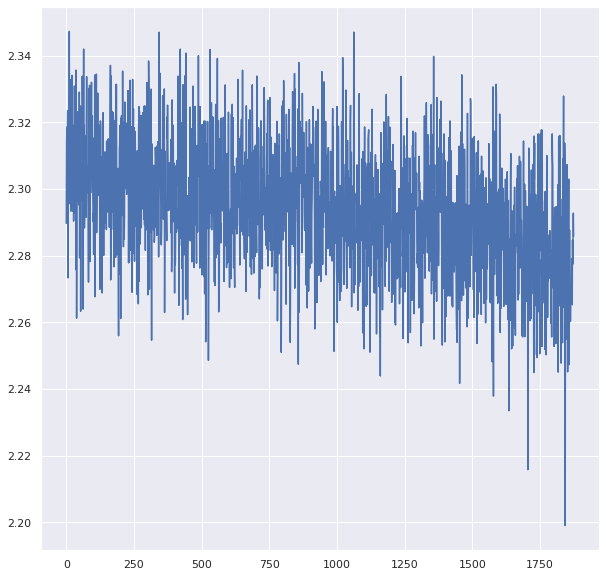

In [18]:
sns.lineplot(x=range(len(baseline_clf.history[0])), y=baseline_clf.history[0])

## Env

In [19]:
env = gym.make('AutoTrain-v0')

In [21]:
"""
baseline: Clf, competitor: ClfEngine, savedir: Path,
U=30, horizon=50, step_reward=0.1, terminal_reward=10, update_penalty=0.1,
num_workers=4, v=False, device=None
"""
env = AutoTrainEnvironment()
env.init(baseline=baseline_clf,  
         competitor=ClfEngine(Classifier(),trnds, valds, accuracy, dev=DEVICE, v=True, opt=optim.Adam), 
         savedir=EXP_DIR, U=30, horizon=100, device=DEVICE, v=True)

[ATE:0]  environment initialised : <__main__.AutoTrainEnvironment object at 0x7f7530d6d860>


/home/jupyter-skenjeye@broadinst-05974/.local/lib/python3.7/site-packages/gym/logger.py:30: UserWarning: WARN: Box bound precision lowered by casting to float32
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))


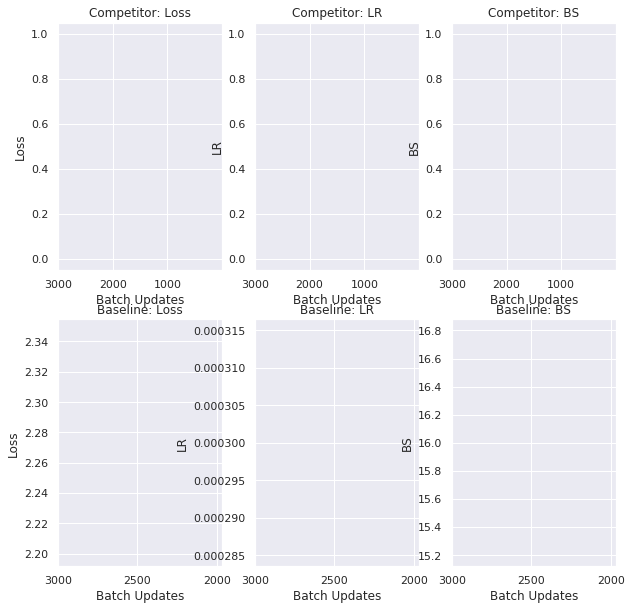

In [22]:
fg = env.render()

In [23]:
env.action_space

Box(4,)

[ATE:0]  action [[1.2, 1.2, 0, 0]] recieved
[clf_engine]  scaled BS by [1.2]; BS=[19]
[clf_engine]  scaled LR by [1.2]; LR=[0.0003]
[clf_engine]  training loop: started for [30] updates; BS=[19] LR=[0.00035999999999999997]!


[clf_engine]  training loop: done!

[ATE:1]  reward at the end of time step is [-0.1]
(128, 128)
(128, 128)
(128, 128)
(128, 128)
(128, 128)
(128, 128)


(array([[[255., 255., 255., ..., 255., 255., 255.],
         [255., 255., 255., ..., 255., 255., 255.],
         [255., 255., 255., ..., 255., 255., 255.],
         ...,
         [255., 255., 255., ..., 255., 255., 255.],
         [255., 255., 255., ..., 255., 255., 255.],
         [255., 255., 255., ..., 255., 255., 255.]],
 
        [[255., 255., 255., ..., 255., 255., 255.],
         [255., 255., 255., ..., 255., 255., 255.],
         [255., 255., 255., ..., 255., 255., 255.],
         ...,
         [255., 255., 255., ..., 255., 255., 255.],
         [255., 255., 255., ..., 255., 255., 255.],
         [255., 255., 255., ..., 255., 255., 255.]],
 
        [[255., 255., 255., ..., 255., 255., 255.],
         [255., 255., 255., ..., 255., 255., 255.],
         [255., 255., 255., ..., 255., 255., 255.],
         ...,
         [255., 255., 255., ..., 255., 255., 255.],
         [255., 255., 255., ..., 255., 255., 255.],
         [255., 255., 255., ..., 255., 255., 255.]],
 
        [[255

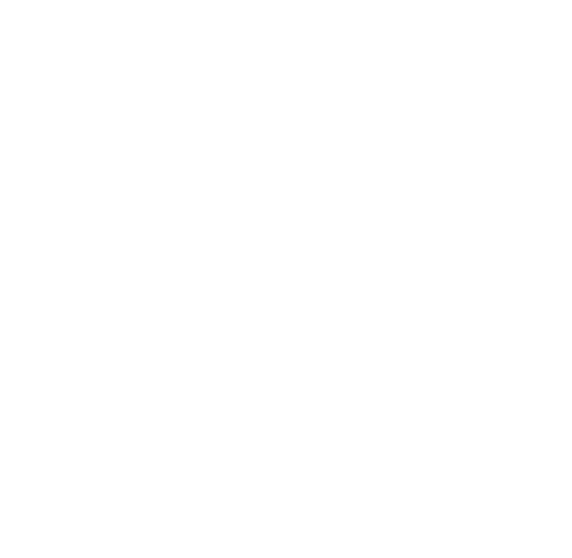

In [ ]:
env.step([1.2,1.2,0,0])

In [27]:
torch.rand(1).item()

0.9065313935279846

In [29]:
np.random.rand()

0.33585136132470184